In [1]:
# Standard libraries
import os

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Machine learning - scikit-learn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, 
    roc_auc_score,
    confusion_matrix, 
    precision_recall_curve, 
    auc,
    f1_score,
    precision_score, 
    recall_score
)

# Machine learning - other frameworks
import xgboost as xgb
import lightgbm as lgb
import shap

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dspp1/product_info.csv
/kaggle/input/dspp1/customer_product.csv
/kaggle/input/dspp1/customer_info.csv
/kaggle/input/dspp1/customer_cases.csv


## Load the Dataset

In [3]:
product_info = pd.read_csv("/kaggle/input/dspp1/product_info.csv")
customer_product = pd.read_csv("/kaggle/input/dspp1/customer_product.csv")
customer_info = pd.read_csv("/kaggle/input/dspp1/customer_info.csv")
customer_cases = pd.read_csv("/kaggle/input/dspp1/customer_cases.csv")

## Exploratory Data Analysis

In [4]:
def style_df(df, caption=''):
    return df.style.set_caption(caption).set_table_styles([
        {'selector': 'th', 'props':[('background-color', '#f0f0f0'),
                                   ('color', 'black'),
                                   ('font-weight', 'bold')]},
        {'selector': 'tr:nth-of-type(odd)','props':[('background-color', '#f9f9f9')]},
    ])

In [5]:
style_df(customer_product.head(), 'Customer Sign-up and Cancellation Dates')

,Unnamed: 0,customer_id,product,signup_date_time,cancel_date_time
0,1,C2448,prd_1,2017-01-01 10:35:09,nan
1,2,C2449,prd_1,2017-01-01 11:39:29,2021-09-05 10:00:02
2,3,C2450,prd_1,2017-01-01 11:42:00,2019-01-13 16:24:55
3,4,C2451,prd_2,2017-01-01 13:32:08,nan
4,5,C2452,prd_1,2017-01-01 13:57:30,2021-06-28 18:06:01


In [6]:
style_df(customer_info.head(), 'Customer Demographics')

,Unnamed: 0,customer_id,age,gender
0,1,C2448,76,female
1,2,C2449,61,male
2,3,C2450,58,female
3,4,C2451,62,female
4,5,C2452,71,male


In [7]:
style_df(customer_cases.head(), 'Call Center Activity')

,Unnamed: 0,case_id,date_time,customer_id,channel,reason
0,1,CC101,2017-01-01 10:32:03,C2448,phone,signup
1,2,CC102,2017-01-01 11:35:47,C2449,phone,signup
2,3,CC103,2017-01-01 11:37:09,C2450,phone,signup
3,4,CC104,2017-01-01 13:28:14,C2451,phone,signup
4,5,CC105,2017-01-01 13:52:22,C2452,phone,signup


In [8]:
style_df(product_info.head(), 'Product Information')

,product_id,name,price,billing_cycle
0,prd_1,annual_subscription,1200,12
1,prd_2,monthly_subscription,125,1


Customer Product Table will be the centre of the star schema. customer_id will be the primary key linking to the customer_centre and customer_info. product_id will be the primary key for the product_info table

### Data Preprocessing and Cleaning

In [9]:
for df_name, df in [("product_info", product_info), 
                    ("customer_product", customer_product),
                    ("customer_info", customer_info), 
                    ("customer_cases", customer_cases)]:
    print(f"\n{df_name} missing values:")
    print(df.isnull().sum())
    
    print(f"\n{df_name} data types:")
    print(df.dtypes)


product_info missing values:
product_id       0
name             0
price            0
billing_cycle    0
dtype: int64

product_info data types:
product_id       object
name             object
price             int64
billing_cycle     int64
dtype: object

customer_product missing values:
Unnamed: 0               0
customer_id              0
product                  0
signup_date_time         0
cancel_date_time    396447
dtype: int64

customer_product data types:
Unnamed: 0           int64
customer_id         object
product             object
signup_date_time    object
cancel_date_time    object
dtype: object

customer_info missing values:
Unnamed: 0     0
customer_id    0
age            0
gender         0
dtype: int64

customer_info data types:
Unnamed: 0      int64
customer_id    object
age             int64
gender         object
dtype: object

customer_cases missing values:
Unnamed: 0     0
case_id        0
date_time      0
customer_id    0
channel        0
reason         0
dtype: in

In [10]:
customer_product.isnull().sum()

Unnamed: 0               0
customer_id              0
product                  0
signup_date_time         0
cancel_date_time    396447
dtype: int64

This suggests that the missing values in cancel date_time are not actual missing values but rather customers who have not cancelled their subscription

In [11]:
customer_product['signup_date_time'] = pd.to_datetime(customer_product['signup_date_time'])
customer_product['cancel_date_time'] = pd.to_datetime(customer_product['cancel_date_time'])
customer_cases['date_time'] = pd.to_datetime(customer_cases['date_time'])

In [12]:
today = pd.to_datetime('2022-01-01')
customer_product['end_date'] = customer_product['cancel_date_time'].fillna(today)
customer_product['tenure_days'] = (customer_product['end_date'] - customer_product['signup_date_time']).dt.days

### Create a Joined Dataframe

In [13]:
joined_df = pd.merge(customer_product,customer_info, how='left', left_on='customer_id', right_on='customer_id')

In [14]:
joined_df = pd.merge(joined_df,product_info, how='left', left_on='product',right_on='product_id')

Joining `customer_cases` with the rest of the DataFrame has a few complications. `customer_cases` exhibits one-to-many relationship problem, where a customer can have multiple support cases. Combining all the data into one table by directly joining results in duplicate customer records.

To solve this, use aggregation, `groupby` and `.agg` operations transform this one-to-many relationship into a one-to-one relationship by summarizing all the `customer_cases` into one row

In [15]:
case_summary = customer_cases.groupby('customer_id').agg({
	'case_id': 'count',
	'date_time':['min','max']
})

In [16]:
case_summary.columns = [
	'total_cases',
	'first_case_date',
	'last_case_date'
]

In [17]:
case_summary['days_between_cases'] = (case_summary['last_case_date'] - case_summary['first_case_date']).dt.days

In [18]:
# Create separate columns for each reason and count the frequency of each reason

reason_counts = customer_cases.groupby(['customer_id', 'reason']).size().unstack(fill_value=0)
reason_counts.columns = [f"reason{col}" for col in reason_counts.columns]
case_summary = case_summary.join(reason_counts)

In [19]:
churn_df = pd.merge(joined_df, case_summary, on='customer_id', how='left')

In [20]:
churn_df['total_cases'] = churn_df['total_cases'].fillna(0)

In [21]:
churn_df = churn_df.drop('Unnamed: 0_x', axis=1)
churn_df = churn_df.drop('Unnamed: 0_y', axis=1)

In [22]:
print(churn_df.isnull().sum())

customer_id                0
product                    0
signup_date_time           0
cancel_date_time      396447
end_date                   0
tenure_days                0
age                        0
gender                     0
product_id                 0
name                       0
price                      0
billing_cycle              0
total_cases                0
first_case_date       250272
last_case_date        250272
days_between_cases    250272
reasonsignup          250272
reasonsupport         250272
dtype: int64


## Clean Merged Dataset

In [23]:
churn_df['total_cases'] = churn_df['total_cases'].fillna(0)
churn_df['first_case_date'] = churn_df['first_case_date'].fillna(pd.NaT)
churn_df['last_case_date'] = churn_df['last_case_date'].fillna(pd.NaT)
churn_df['days_between_cases'] = churn_df['days_between_cases'].fillna(0)
churn_df['ever_contacted_support'] = churn_df['total_cases'].gt(0).astype(int)

In [24]:
reason_columns = [col for col in churn_df.columns if col.startswith('reason')]
churn_df[reason_columns] = churn_df[reason_columns].fillna(0)

In [25]:
print(churn_df.isnull().sum())

customer_id                    0
product                        0
signup_date_time               0
cancel_date_time          396447
end_date                       0
tenure_days                    0
age                            0
gender                         0
product_id                     0
name                           0
price                          0
billing_cycle                  0
total_cases                    0
first_case_date           250272
last_case_date            250272
days_between_cases             0
reasonsignup                   0
reasonsupport                  0
ever_contacted_support         0
dtype: int64


## Defining Churn - Target Variable

Earlier defined churn as has cancellation_date = Churned. This is good retrospectively, but it's not predictive. Using a time-window approach here (will churn in Next X Days). This is where the business value is. The purpose of churn prediction is preventing future churn, not explaining past churn

In [26]:
cutoff_date = pd.to_datetime('2021-10-03')

churn_df['will_churn_next_90d'] = (
    (churn_df['cancel_date_time'] > cutoff_date) & 
    (churn_df['cancel_date_time'] <= cutoff_date + pd.Timedelta(days = 90))
).astype(int)

## Feature Engineering

Tenure is one of the strongest predictors of churn in SaaS businesses. Subtracting the reference data (`today`) with the `signup_date_time`, gives tenure (`days_since_signup`)

In [27]:
churn_df['days_since_signup'] = (today - churn_df['signup_date_time']).dt.days 

Measures how long after signing up a customer first reached out to support (if they ever did). For the customers who did not contact support at all, fill the rows with -1 instead of 0. 0 would indicated the customer contacted support the exact same day they signed up. -1 or any negative value is impossible in real data, since a customer can't contact support before they signup

In [28]:
churn_df['age_group'] = pd.cut(churn_df['age'],
                              bins  = [0, 30, 45, 60, 75, 100],
                              labels  = ['<30', '30-45', '46-60','61-75','75+'])

In [29]:
churn_df['tenure_group'] = pd.cut(churn_df['tenure_days'],
                                 bins = [0, 90, 180, 365, 730, float('inf')],
                                 labels = ['0-3mo', '3-6mo', '6-12mo','1-2yr', '2yr+'])

Filter the dataset to keep only the customers who either churned after the cutoff date or who never churned at all. 

This approach ensures:

- All customers in the dataset had enough time to show their behavior (signed up before cutoff)
- The dataset avoids "look-ahead bias" by excluding customers who churned before the cutoff date
- It creates a clear point-in-time snapshot where the modeling task becomes "predict which active customers as of the cutoff date will eventually churn"

In [30]:
modeling_df = churn_df[churn_df['signup_date_time'] < cutoff_date]

modeling_df = modeling_df[
    (modeling_df['cancel_date_time'] > cutoff_date) | 
    (modeling_df['cancel_date_time'].isna())
]

In [31]:
churn_df.head()

,customer_id,product,signup_date_time,cancel_date_time,end_date,tenure_days,age,gender,product_id,name,...,first_case_date,last_case_date,days_between_cases,reasonsignup,reasonsupport,ever_contacted_support,will_churn_next_90d,days_since_signup,age_group,tenure_group
0,C2448,prd_1,2017-01-01 10:35:09,NaT,2022-01-01 00:00:00,1825,76,female,prd_1,annual_subscription,...,2017-01-01 10:32:03,2017-01-01 10:32:03,0.0,1.0,0.0,1,0,1825,75+,2yr+
1,C2449,prd_1,2017-01-01 11:39:29,2021-09-05 10:00:02,2021-09-05 10:00:02,1707,61,male,prd_1,annual_subscription,...,2017-01-01 11:35:47,2017-01-01 11:35:47,0.0,1.0,0.0,1,0,1825,61-75,2yr+
2,C2450,prd_1,2017-01-01 11:42:00,2019-01-13 16:24:55,2019-01-13 16:24:55,742,58,female,prd_1,annual_subscription,...,2017-01-01 11:37:09,2017-01-01 11:37:09,0.0,1.0,0.0,1,0,1825,46-60,2yr+
3,C2451,prd_2,2017-01-01 13:32:08,NaT,2022-01-01 00:00:00,1825,62,female,prd_2,monthly_subscription,...,2017-01-01 13:28:14,2017-03-31 12:06:58,88.0,1.0,1.0,1,0,1825,61-75,2yr+
4,C2452,prd_1,2017-01-01 13:57:30,2021-06-28 18:06:01,2021-06-28 18:06:01,1639,71,male,prd_1,annual_subscription,...,2017-01-01 13:52:22,2017-01-01 13:52:22,0.0,1.0,0.0,1,0,1825,61-75,2yr+


Normalize billing calculations as monthly_spend. Currently, there are two main product types; a 125 monthly subscription (billing_cycles = 1) and a 1,200 annual subscription (billing_cycles = 12). Without normalization, the price difference makes it hard to compare these customers. The annual customer appears to spend much more, but their monthly commitment is similar. Monthly subscribers pay 25% more every month, which might influence their churn behavior

In [32]:
modeling_df['monthly_spend'] = modeling_df['price'] / modeling_df['billing_cycle']

In [33]:
modeling_df['tenure_at_cutoff'] = (cutoff_date - modeling_df['signup_date_time']).dt.days
modeling_df['tenure_months'] = (modeling_df['tenure_at_cutoff'] / 30).round()

Measure how long after signing up a customer first reached out to support (if they ever did). For the customers who did not contact support at all, fill the rows with -1 instead of 0. 0 would indicated the customer contacted support the exact same day they signed up. -1 or any negative value is impossible in real data, since a customer can't contact support before they signup

In [34]:
mask = churn_df['ever_contacted_support'] == 1
churn_df.loc[mask,'days_to_first_contact'] = (churn_df.loc[mask, 'first_case_date'] - churn_df.loc[mask, 'signup_date_time']).dt.days
churn_df['days_to_first_contact'] = churn_df['days_to_first_contact'].fillna(-1)

Indicate whether a customer's *most recent support interaction occurred before* the defined `cutoff_date`

In [35]:
mask = modeling_df['ever_contacted_support'] == 1

modeling_df.loc[mask, 'support_before_cutoff'] = (
    modeling_df.loc[mask, 'last_case_date'] < cutoff_date
).astype(int)

modeling_df['support_before_cutoff'] = modeling_df['support_before_cutoff'].fillna(0)

Calculate how many days passed between the `cutoff_date` and the customer's last support contact, *but only if that last contact happened before the cutoff*.

In [36]:
mask = modeling_df['support_before_cutoff'] == 1
modeling_df.loc[mask, 'days_since_last_contact'] = (
    cutoff_date - modeling_df.loc[mask, 'last_case_date']
).dt.days

modeling_df['days_since_last_contact'] = modeling_df['days_since_last_contact'].fillna(999)

Calculate the average frequency of support contacts per month over the customer's tenure 

In [37]:
mask = modeling_df['ever_contacted_support'] == 1

modeling_df.loc[mask, 'monthly_contact_rate'] = (
    modeling_df.loc[mask, 'total_cases'] / (modeling_df.loc[mask, 'tenure_months'] + 1)
)

modeling_df['monthly_contact_rate'] = modeling_df['monthly_contact_rate'].fillna(0)

In [38]:
modeling_df['support_level'] = pd.cut(
    modeling_df['monthly_contact_rate'],
    bins = [-0.001, 0 , 0.2, 0.5, 1, float('inf')],
    labels = ['None', 'Low', 'Medium', 'High', 'Very High']
)

In [39]:
target = 'will_churn_next_90d'
segments = ['age_group', 'tenure_group', 'support_level', 'product']

for segment in segments:
    churn_by_segment = modeling_df.groupby(segment, observed=True)[target].agg(['mean', 'count'])
    churn_by_segment['mean'] *= 100
    print(f"\nChurn rate by {segment}:")
    print(churn_by_segment.sort_values('mean', ascending=False))


Churn rate by age_group:
               mean   count
age_group                  
75+        4.382609    2875
30-45      4.260450   24880
46-60      4.008111  195279
61-75      3.995778  163898
<30        3.880597    1005

Churn rate by tenure_group:
                   mean   count
tenure_group                   
0-3mo         75.802998     934
3-6mo          4.752750   37452
1-2yr          3.925560  119881
6-12mo         3.703624   93260
2yr+           3.630965  136410

Churn rate by support_level:
                   mean   count
support_level                  
Medium         4.955527   31480
Very High      4.945055     546
High           4.672024    5351
Low            4.182353  162827
None           3.704197  187733

Churn rate by product:
             mean   count
product                  
prd_2    5.389810  135348
prd_1    3.288346  252589


Extremely high churn rate (76%) for customers with a tenure of 0-3 months. Might be dealing with 'onboarding cliff' in subscription businesses, could be a free trial effect, but the data does not indicate that the service offers a free trial, so I am making an assumption here. 

In [40]:
modeling_df['tenure_weeks'] = (modeling_df['tenure_at_cutoff'] / 7).astype(int)
new_churn = modeling_df[modeling_df['tenure_at_cutoff'] < 90]
weekly_churn = new_churn.groupby('tenure_weeks')['will_churn_next_90d'].agg(['mean','count'])
weekly_churn['mean'] *= 100

print(weekly_churn)

new_product_churn = new_churn.groupby(['product', 'tenure_weeks'])['will_churn_next_90d'].mean() * 100

print(new_product_churn)

                  mean  count
tenure_weeks                 
0             4.268293   2460
1             4.101951   2511
2             3.953749   2681
3             3.834472   2634
4             4.235727   2715
5             3.463961   2858
6             5.005325   2817
7             3.766542   2947
8             3.993344   3005
9             4.386808   3123
10            4.700991   3127
11            3.773585   3180
12            4.515522   3189
product  tenure_weeks
prd_1    0               3.568465
         1               2.510121
         2               3.403933
         3               3.448276
         4               3.419453
         5               2.620087
         6               2.964570
         7               2.746845
         8               2.709848
         9               2.927478
         10              3.715992
         11              2.754644
         12              3.388747
prd_2    0               4.940239
         1               5.642633
         2        

In [41]:
tenure_check = modeling_df[modeling_df['tenure_group'] == '0-3mo']
print(f"Count of customers in 0-3mo group: {len(tenure_check)}")

print(tenure_check['tenure_at_cutoff'].describe())

print(f"Churn rate in 0-3mo group: {tenure_check['will_churn_next_90d'].mean()*100:.2f}%")

print(tenure_check.groupby('product')['will_churn_next_90d'].mean()*100)

Count of customers in 0-3mo group: 934
count    934.000000
mean      23.361884
std       23.019626
min        0.000000
25%        0.000000
50%       18.000000
75%       39.000000
max       89.000000
Name: tenure_at_cutoff, dtype: float64
Churn rate in 0-3mo group: 75.80%
product
prd_1    71.111111
prd_2    78.745645
Name: will_churn_next_90d, dtype: float64


We have 934 customers who joined less than 3 months before the cutoff date. On average, these customers are only subscribed for 23 days. Half of them (median) have been customers for 18 days or less. 75% of the customers will cancel within the next 90 days. This is much higher than other tenure groups' 3-5% churn rate. There is also a difference in monthly subscribers (78.7%) who are more likely to churn compared to annual customers (71.1%)

If we were to acquire 100 customers, ~75 would leave within the first 3 months. A large amount of leakage happening in the initial stages of the subscription signup

The customer journey pattern seems to be Signup -> [Critical 3-month decision period] -> Stable Relationship

Given these dramatic differences, the best approach is segment-based modeling, particularly separating new customers from established ones 

## Customer Segmentation

In [42]:
modeling_df['new_customer'] = modeling_df['tenure_at_cutoff'] < 90 # 0-3 months
modeling_df.loc[modeling_df['new_customer'], 'signup_day_of_week'] = modeling_df.loc[modeling_df['new_customer'], 'signup_date_time'].dt.dayofweek
modeling_df.loc[modeling_df['new_customer'], 'signup_month'] = modeling_df.loc[modeling_df['new_customer'], 'signup_date_time'].dt.month

In [43]:
new_customer_df = modeling_df[modeling_df['new_customer']].copy()
established_customer_df = modeling_df[~modeling_df['new_customer']].copy()

print(f"New customers: {len(new_customer_df)} ({len(new_customer_df)/len(modeling_df):.1%})")
print(f"Established customers: {len(established_customer_df)} ({len(established_customer_df)/len(modeling_df):.1%}) ")

New customers: 37247 (9.6%)
Established customers: 350690 (90.4%) 


Dealing with a significant class imbalance here - Will need feature engineering for each segment and then build separate models

## New Customers

In [44]:
new_features = [
    'product',
    'days_since_signup',
    'ever_contacted_support',
    'total_cases',
    'age',
    'gender',
    'signup_month',
    'signup_day_of_week'
]

In [45]:
new_customer_df['signup_day_of_week'] = new_customer_df['signup_date_time'].dt.dayofweek
new_customer_df['signup_month'] = new_customer_df['signup_date_time'].dt.month

In [46]:
new_customer_df['days_to_first_contact'] = new_customer_df.apply(
    lambda x: (x['first_case_date'] - x['signup_date_time']).days
    if x['ever_contacted_support'] == 1 else -1, axis = 1
)

### New Customer Baseline Model Building

In [47]:
X_new = new_customer_df[new_features]
y_new = new_customer_df['will_churn_next_90d']

X_new = pd.get_dummies(X_new, drop_first=True)
   
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y_new, test_size = 0.20, random_state = 0, stratify = y_new
)
new_churn_rate = y_new.mean()
print(f"New customer churn rate: {new_churn_rate: .4%}")
weights_new = {0:1, 1:3} # Non-churners get 3x the weight
print(f"Using class weights for new model: {weights_new}")

new_model = RandomForestClassifier(n_estimators = 100, class_weight = weights_new, random_state = 0)
new_model.fit(X_train, y_train)

New customer churn rate:  4.1587%
Using class weights for new model: {0: 1, 1: 3}


RandomForestClassifier(class_weight={0: 1, 1: 3}, random_state=0)

## Established Customers

In [48]:
established_customer_df['billing_cycles_completed'] = (
    established_customer_df['tenure_days'] / (established_customer_df['billing_cycle'] * 30).astype(int)  
)

established_customer_df['recent_support'] = (
    established_customer_df['days_since_last_contact'] < 30).astype(int)

established_features = [
    'tenure_group',
    'product',
    'support_level',
    'days_since_last_contact',
    'monthly_contact_rate',
    'price',
    'billing_cycle',
    'age_group',
    'gender',
    'billing_cycles_completed',
    'recent_support'
]

### Established Customer Baseline Model Building

In [49]:
X_established = established_customer_df[established_features]
y_established = established_customer_df['will_churn_next_90d']

X_established = pd.get_dummies(X_established, drop_first = True, dummy_na = False)

X_train_est, X_test_est, y_train_est, y_test_est = train_test_split(
    X_established, y_established,
    test_size = 0.20,
    random_state = 0,
    stratify = y_established
)

final_feature_names = X_established.columns.tolist() 

established_churn_rate = y_established.mean()
print(f"Established customer churn rate: {established_churn_rate: .2%}")
weight_est = {0:1,1:5}
print(f"Using class weights for established model: {weight_est}")

established_model = RandomForestClassifier(n_estimators=100,
                                          class_weight = weight_est,
                                          random_state = 0)

established_model.fit(X_train_est, y_train_est)

Established customer churn rate:  4.01%
Using class weights for established model: {0: 1, 1: 5}


RandomForestClassifier(class_weight={0: 1, 1: 5}, random_state=0)

## Baseline Model Evaluation

Evaluating New Customer Model (Random Forest Baseline)...
Evaluation Report for New Customer RF
              precision    recall  f1-score   support

No Churn (0)       0.96      0.97      0.97      7140
   Churn (1)       0.06      0.04      0.05       310

    accuracy                           0.93      7450
   macro avg       0.51      0.51      0.51      7450
weighted avg       0.92      0.93      0.93      7450

ROC AUC Score: 0.5414
Precision-Recall Curve AUC (PRC AUC): 0.0481

 Confusion Matrix:


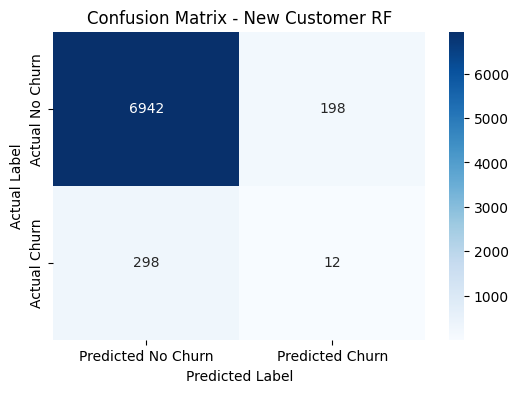



Evaluating Established Customer Model (Random Forest Baseline) ...
Evaluation Report for Established Customer RF
              precision    recall  f1-score   support

No Churn (0)       0.97      0.99      0.98     67328
   Churn (1)       0.59      0.32      0.42      2810

    accuracy                           0.96     70138
   macro avg       0.78      0.66      0.70     70138
weighted avg       0.96      0.96      0.96     70138

ROC AUC Score: 0.7615
Precision-Recall Curve AUC (PRC AUC): 0.4083

 Confusion Matrix:


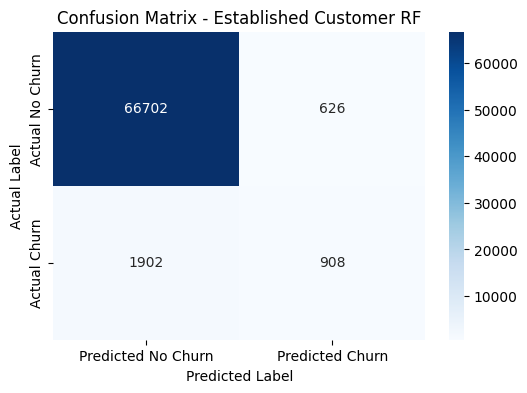

In [50]:
def evaluate_model(model, X_test, y_test, model_name = "Model"):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    print(f'Evaluation Report for {model_name}')
    print(classification_report(y_test, y_pred, target_names = ['No Churn (0)', 'Churn (1)']))

    roc_auc = roc_auc_score(y_test, y_prob)
    print(f'ROC AUC Score: {roc_auc:.4f}')

    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    prc_auc = auc(recall, precision)
    print(f'Precision-Recall Curve AUC (PRC AUC): {prc_auc:.4f}')

    cm = confusion_matrix(y_test, y_pred)
    print("\n Confusion Matrix:")

    plt.figure(figsize = (6,4))
    sns.heatmap(cm, annot = True, fmt='d', cmap='Blues',
               xticklabels = ['Predicted No Churn', 'Predicted Churn'],
               yticklabels = ['Actual No Churn', 'Actual Churn'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print(""* (len(model_name) +24))

    return {
        'roc_auc': roc_auc,
        'prc_auc': prc_auc,
        'f1_churn': f1_score(y_test, y_pred, pos_label=1),
        'recall_churn': recall_score(y_test, y_pred, pos_label=1),
        'precision_churn': precision_score(y_test, y_pred, pos_label=1)
    }

print("Evaluating New Customer Model (Random Forest Baseline)...")
new_model_metrics = evaluate_model(new_model, X_test, y_test, 'New Customer RF')

print("\nEvaluating Established Customer Model (Random Forest Baseline) ...")
established_model_metrics = evaluate_model(established_model, X_test_est, y_test_est, "Established Customer RF")

baseline_metrics = {
    'New RF': new_model_metrics,
    'Established RF': established_model_metrics
}

New Customer Random Forest Baseline

- `Precision: 0.06` - Extremely poor, when this model predicts a new customer will churn, it is right 6% of the time
- `Recall: 0.04`  - Extremely poor, model only identifies 4% of the new customers who actually churned, it missed 96% of them
- `F1-score: 0.05` - Extremely poor, confirms the model is failing badly on the churn class

Overall metrics

- `Accuracy: 0.93` - Looks high but is very misleading: Since only ~4% of churn (310/7450), a model predicting ‘No Churn’ for everyone would get a ~96% accuracy, this model isn’t much better
- `ROC AUC: 0.5414` - Very close to 0.5 (random chance) - indicates the model has almost no ability to distinguish between churning and non-churning new customers
- `PRC AUC: 0.0481` - Extremely low. For an imbalanced dataset like this (~4% positive), a random model would have a PRC AUC of around 0.04, this model is barely above random guessing

The baseline Random Forest for **new customers is performing terribly**. The class weights were not enough, It has no predictive power for identifying churn in this segment. Will need to try different features and algorithm. **Will need to put this segment on hold for now**

-----------------------------------------------

Established Customer Random Forest Baseline

Performance on Churn (Class ‘1’)

- `Precision: 0.59` - Decent. When this model predicts an established customer will churn, it’s correct 59% of the time - useable but still means 41% are false alarms
- `Recall: 0.32` - Poor. The model only identifies 32% (less than a 3rd) of the established customer who churned. It misses the majority (68%)
- `F1-score: 0.42` - Mediocre. Balanced score reflecting decent precision but poor recall

Overall metrics:

- `Accuracy: 0.96` - High, but again, influenced by the imbalance (~4% churn rate)
- `ROC AUC: 0.7615` - Fair/Okay, significantly better than the random 0.5. Shows some ability to distinguish between classes
- `PRC AUC: 0.4093`- Fair/Okay. Considerably better than random (~0.04) for this imbalance level. Indicates reasonable predictive signal

The baseline Random Forest for **established customers shows potential but is flawed**. It is significantly better than the new customer model. Its main weakness is **low recall** - failing to identify most customers who will churn. The 5x weight class helped precision but wasn’t enough to catch more churners

## Established Customer XGBoost Modeling and Tuning


Calculated scale_pos_weight for Established XGBoost: 23.96

Training default XGBoost model for Established Customers...

Evaluating Established Customer Model (XGBoost Default)...
Evaluation Report for Established Customer XGB
              precision    recall  f1-score   support

No Churn (0)       0.98      0.86      0.92     67328
   Churn (1)       0.15      0.59      0.24      2810

    accuracy                           0.85     70138
   macro avg       0.57      0.73      0.58     70138
weighted avg       0.95      0.85      0.89     70138

ROC AUC Score: 0.8201
Precision-Recall Curve AUC (PRC AUC): 0.4760

 Confusion Matrix:


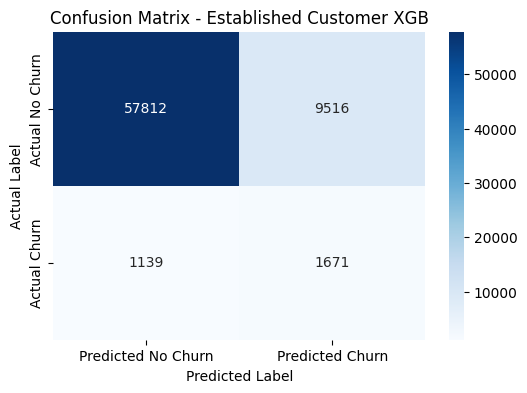

In [51]:
# XGBoost

neg_count_est = (y_train_est == 0).sum()
pos_count_est = (y_train_est == 1).sum()
scale_pos_weight_est = neg_count_est / pos_count_est
print(f'\nCalculated scale_pos_weight for Established XGBoost: {scale_pos_weight_est:.2f}')

xgb_model_est = xgb.XGBClassifier(
    objective = 'binary:logistic',
    eval_metric = 'logloss',
    use_label_encoder = False,
    scale_pos_weight = scale_pos_weight_est,
    random_state = 0
)

print('\nTraining default XGBoost model for Established Customers...')
xgb_model_est.fit(X_train_est, y_train_est)

print('\nEvaluating Established Customer Model (XGBoost Default)...')
xgb_est_metrics = evaluate_model(xgb_model_est, X_test_est, y_test_est, 'Established Customer XGB')

Established Customer Model:

    The RF baseline missed too many churners (low recall).
    The default XGBoost found more churners (good recall) but was very inaccurate in its churn predictions (low precision).
    XGBoost shows more promise due to higher AUC scores, indicating better potential.

### XGBoost Tuning

In [52]:
xgb_base = xgb.XGBClassifier(
    objective = 'binary:logistic',
    eval_metric = 'logloss',
    use_label_encoder = False,
    random_state = 0
)

param_distributions = {
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop=1000, num=10)],
    'max_depth': [3,4,5,6,7,8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'scale_pos_weight': [5,10,15,20,24],
    'subsample': [0.7,0.8,0.9,1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

n_iterations = 50

cv_folds = 3

scoring_metric = 'f1'

print(f"Starting Randomized Search with {n_iterations} iterations, {cv_folds}-fold CV, optimizing for '{scoring_metric}'...")

random_search = RandomizedSearchCV(
    estimator = xgb_base,
    param_distributions = param_distributions,
    n_iter = n_iterations,
    n_jobs = -1,
    cv = cv_folds,
    verbose = 1,
    random_state = 0
)

random_search.fit(X_train_est, y_train_est)

print('\nRandomized Search Complete')
print(f"Best Score ({scoring_metric}) found: {random_search.best_score_:.4f}")
print("Best Parameters found:")
print(random_search.best_params_)

Starting Randomized Search with 50 iterations, 3-fold CV, optimizing for 'f1'...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Randomized Search Complete
Best Score (f1) found: 0.9743
Best Parameters found:
{'subsample': 1.0, 'scale_pos_weight': 5, 'n_estimators': 900, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.7}


## Established Customer Final Model Evaluation and Interpretation


Evaluating the Best Tuned XGBoost Model on the Test Set...
Evaluation Report for Established Customer Tuned XGB
              precision    recall  f1-score   support

No Churn (0)       0.98      1.00      0.99     67328
   Churn (1)       0.95      0.40      0.56      2810

    accuracy                           0.98     70138
   macro avg       0.96      0.70      0.77     70138
weighted avg       0.97      0.98      0.97     70138

ROC AUC Score: 0.8292
Precision-Recall Curve AUC (PRC AUC): 0.5149

 Confusion Matrix:


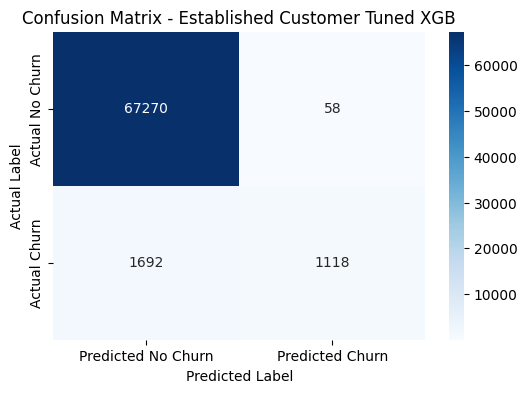



Comparison (Recall / Precision / F1 / PRC AUC / ROC AUC):
Baseline RF:  0.32 / 0.59 / 0.42 / 0.4083 / 0.7615
Tuned XGB:    0.40 / 0.95 / 0.56 / 0.5149 / 0.8292


In [53]:
best_xgb_model = random_search.best_estimator_

print("\nEvaluating the Best Tuned XGBoost Model on the Test Set...")
tuned_xgb_metrics = evaluate_model(best_xgb_model, X_test_est, y_test_est, 'Established Customer Tuned XGB')

print("\nComparison (Recall / Precision / F1 / PRC AUC / ROC AUC):")

print(f"Baseline RF:  {baseline_metrics['Established RF']['recall_churn']:.2f} / {baseline_metrics['Established RF']['precision_churn']:.2f} / {baseline_metrics['Established RF']['f1_churn']:.2f} / {baseline_metrics['Established RF']['prc_auc']:.4f} / {baseline_metrics['Established RF']['roc_auc']:.4f}")
print(f"Tuned XGB:    {tuned_xgb_metrics['recall_churn']:.2f} / {tuned_xgb_metrics['precision_churn']:.2f} / {tuned_xgb_metrics['f1_churn']:.2f} / {tuned_xgb_metrics['prc_auc']:.4f} / {tuned_xgb_metrics['roc_auc']:.4f}")


Top 20 Features by Importance (XGBoost Built-in):
                     Feature  Importance
6         tenure_group_3-6mo    0.535142
1       monthly_contact_rate    0.075205
4   billing_cycles_completed    0.059344
3              billing_cycle    0.053441
8         tenure_group_1-2yr    0.051230
2                      price    0.046264
7        tenure_group_6-12mo    0.037301
0    days_since_last_contact    0.026869
9          tenure_group_2yr+    0.017336
11         support_level_Low    0.017140
10             product_prd_2    0.015845
12      support_level_Medium    0.014056
18             age_group_75+    0.007627
13        support_level_High    0.007614
16           age_group_46-60    0.007538
15           age_group_30-45    0.007509
17           age_group_61-75    0.007499
19               gender_male    0.007222
5             recent_support    0.005816
14   support_level_Very High    0.000000


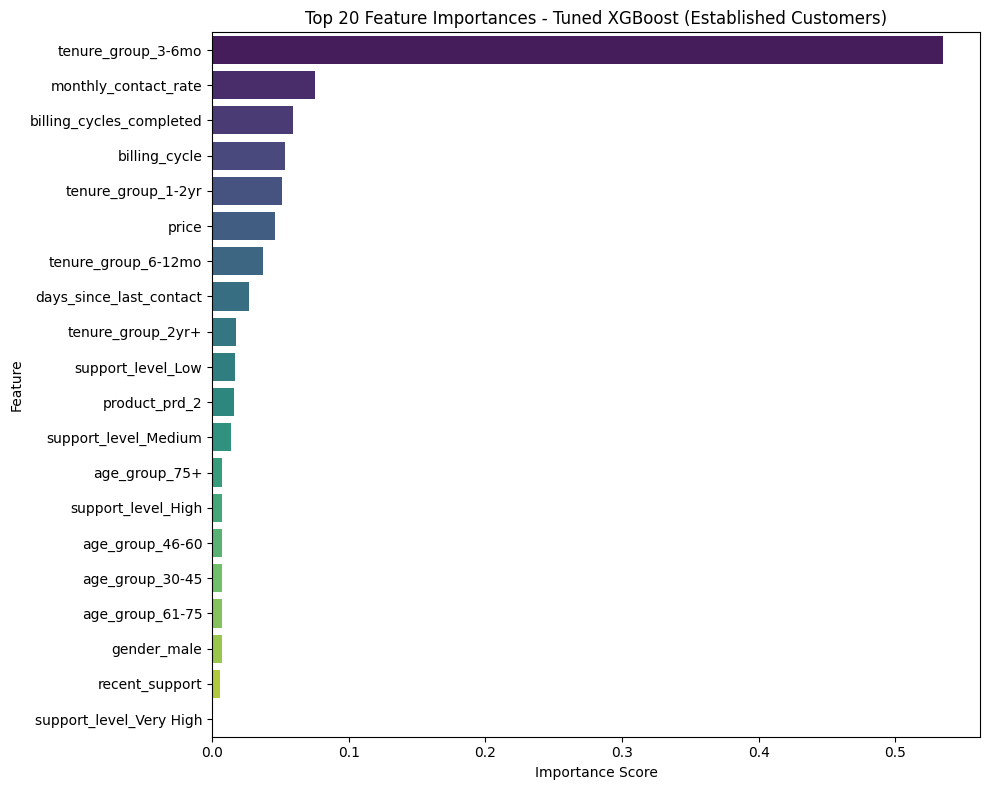

In [54]:
importance_scores = best_xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': final_feature_names,
    'Importance': importance_scores
})

feature_importance_df  = feature_importance_df.sort_values(by='Importance', ascending=False)

top_n = 20 
print(f"\nTop {top_n} Features by Importance (XGBoost Built-in):")
print(feature_importance_df.head(top_n))

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n), palette='viridis')
plt.title(f'Top {top_n} Feature Importances - Tuned XGBoost (Established Customers)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout() 
plt.show()

In [55]:
shap.initjs()

In [56]:
print("Creating SHAP explainer...")
explainer = shap.TreeExplainer(best_xgb_model)

try:
    if not isinstance(X_test_est, pd.DataFrame):
        X_test_est_df = pd.DataFrame(X_test_est, columns=final_feature_names) 
    else:
        X_test_est_df = X_test_est

    shap_values = explainer.shap_values(X_test_est_df)
    print("SHAP values calculated.")

except Exception as e:
    print(f"Error calculating SHAP values: {e}")
    print("Ensure X_test_est is a pandas DataFrame or can be converted with final_feature_names.")
    shap_values = None 

Creating SHAP explainer...
SHAP values calculated.



--- SHAP Summary Plots ---
Generating SHAP Bar Plot (Mean Absolute SHAP Value)...


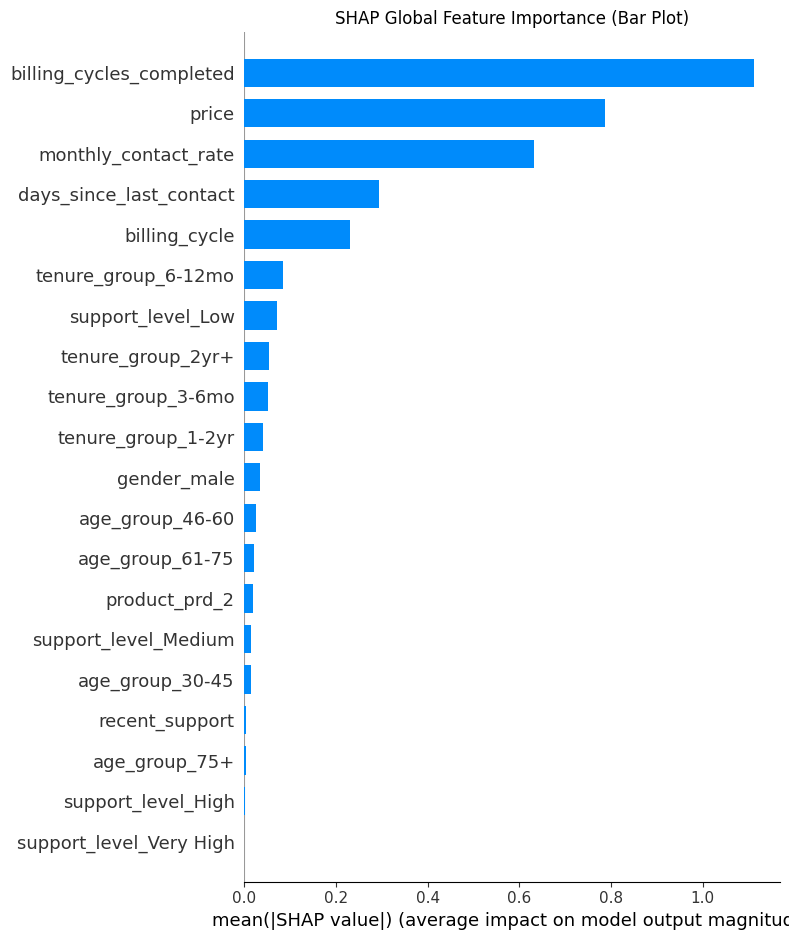


Generating SHAP Beeswarm Plot...


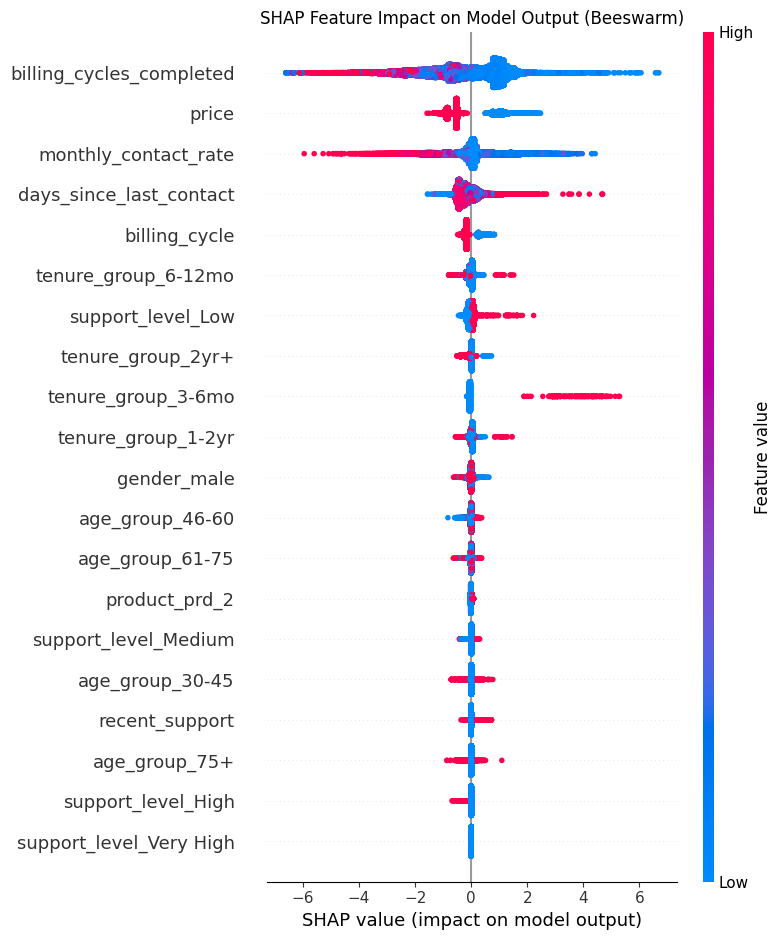


--- SHAP Dependence Plots (Examples) ---
Generating SHAP Dependence Plot for 'monthly_contact_rate'...


<Figure size 640x480 with 0 Axes>

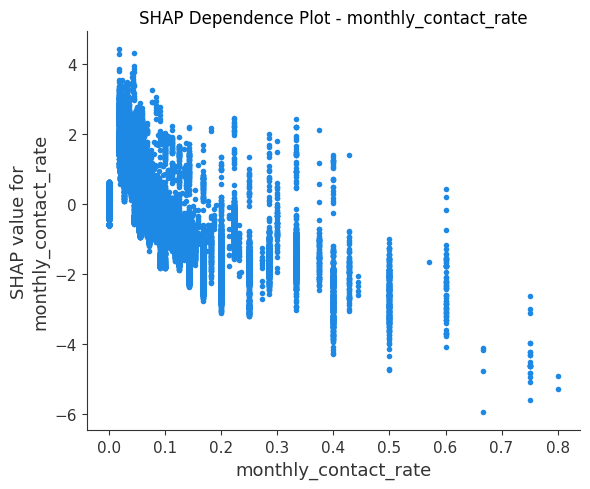

Generating SHAP Dependence Plot for 'billing_cycles_completed'...


<Figure size 640x480 with 0 Axes>

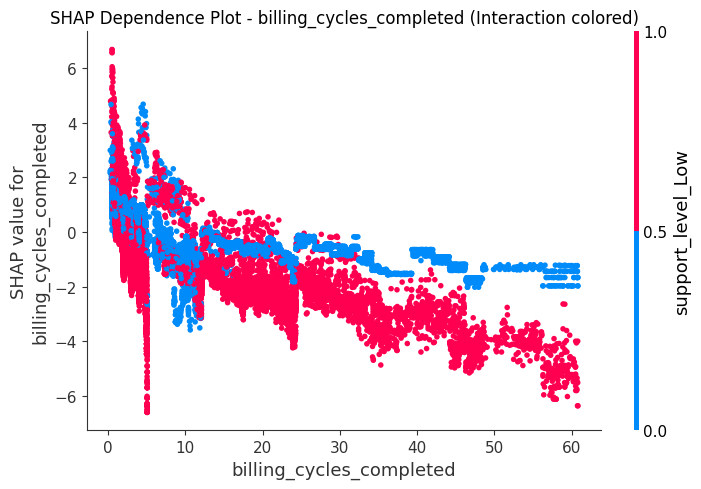

In [57]:
  if shap_values is not None:
    print("\n--- SHAP Summary Plots ---")
    
    print("Generating SHAP Bar Plot (Mean Absolute SHAP Value)...")
    plt.figure() # Create a new figure context
    shap.summary_plot(shap_values, X_test_est_df, plot_type="bar", max_display=top_n, show=False)
    plt.title('SHAP Global Feature Importance (Bar Plot)')
    plt.tight_layout()
    plt.show()
   
    print("\nGenerating SHAP Beeswarm Plot...")
    plt.figure()
    shap.summary_plot(shap_values, X_test_est_df, max_display=top_n, show=False)
    plt.title('SHAP Feature Impact on Model Output (Beeswarm)') 
    plt.tight_layout()
    plt.show()

    print("\n--- SHAP Dependence Plots (Examples) ---")
   
    top_feature_1 = 'monthly_contact_rate' 
    top_feature_2 = 'billing_cycles_completed' 

    try:
        print(f"Generating SHAP Dependence Plot for '{top_feature_1}'...")
        plt.figure()
        shap.dependence_plot(top_feature_1, shap_values, X_test_est_df, interaction_index=None, show=False) 
        plt.title(f'SHAP Dependence Plot - {top_feature_1}')
        plt.tight_layout()
        plt.show()

        print(f"Generating SHAP Dependence Plot for '{top_feature_2}'...")
        plt.figure() # Create a new figure context
        shap.dependence_plot(top_feature_2, shap_values, X_test_est_df, interaction_index="auto", show=False) # 'auto' tries to find interaction
        plt.title(f'SHAP Dependence Plot - {top_feature_2} (Interaction colored)')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not generate one or more dependence plots: {e}")
        print("Check if feature names exist exactly in X_test_est_df.columns")

else:
    print("Skipping SHAP plots due to calculation error.")

### Revisit New Customer Model

In [58]:
churn_df['churned_within_90d'] = (
    (churn_df['cancel_date_time'].notna()) &
    (churn_df['tenure_days'] < 90)
).astype(int)

new_churn_actual_rate = churn_df['churned_within_90d'].mean()
print(f'Overall rate of churn within first 90 days: {new_churn_actual_rate:.2%}')
print(churn_df['churned_within_90d'].value_counts())

Overall rate of churn within first 90 days: 3.06%
churned_within_90d
0    493351
1     15581
Name: count, dtype: int64


In [59]:
try: 
    idx_first_case_per_customer = customer_cases.loc[customer_cases.groupby('customer_id')['date_time'].idxmin()]
    first_case_details = idx_first_case_per_customer[['customer_id', 'reason','channel']].rename(columns={
        'reason':'first_case_reason',
        'channel':'first_case_channel'
    })

    if 'first_case_reason' in churn_df.columns:
        churn_df = churn_df.drop(columns=['first_case_reaon'])
    if 'first_case_channel' in churn_df.columns:
        churn_df = churn_df.drop(columns=['first_case_channel'])

    churn_df = pd.merge(churn_df, first_case_details, on = 'customer_id', how = 'left')
    churn_df['first_case_reason'] = churn_df['first_case_reason'].fillna('No_Contact')
    churn_df['first_case_channel'] = churn_df['first_case_channel'].fillna('No_Contact')

    print(churn_df['first_case_reason'].value_counts())
    print(churn_df['first_case_channel'].value_counts())

except KeyError as e:
    print(f"Error: A required column is missing. Make sure 'customer_cases' DataFrame is loaded correctly. Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred during first case feature engineering: {e}")

first_case_reason
No_Contact    250272
signup        129527
support       129133
Name: count, dtype: int64
first_case_channel
No_Contact    250272
phone         230416
email          28244
Name: count, dtype: int64


In [60]:
churn_df['signup_month'] = churn_df['signup_date_time'].dt.month
churn_df['signup_day_of_week'] = churn_df['signup_date_time'].dt.dayofweek
churn_df['contacted_within_7d'] = (churn_df['days_to_first_contact'] >= 0 & (churn_df['days_to_first_contact'] <= 7 )).astype(int)

In [61]:
new_churn_features = [
    'product',
    'price',
    'age_group',
    'gender',
    'signup_month',
    'signup_day_of_week',
    'contacted_within_7d',
    'days_to_first_contact',
    'first_case_reason',
    'first_case_channel'
]

print('\nColumns available for new churn features:', churn_df.columns)
X_new = churn_df[new_churn_features].copy()
y_new = churn_df['churned_within_90d']

print('\nFeatures selected for new Churn model (Revised):')
print(X_new.info())


Columns available for new churn features: Index(['customer_id', 'product', 'signup_date_time', 'cancel_date_time',
       'end_date', 'tenure_days', 'age', 'gender', 'product_id', 'name',
       'price', 'billing_cycle', 'total_cases', 'first_case_date',
       'last_case_date', 'days_between_cases', 'reasonsignup', 'reasonsupport',
       'ever_contacted_support', 'will_churn_next_90d', 'days_since_signup',
       'age_group', 'tenure_group', 'days_to_first_contact',
       'churned_within_90d', 'first_case_reason', 'first_case_channel',
       'signup_month', 'signup_day_of_week', 'contacted_within_7d'],
      dtype='object')

Features selected for new Churn model (Revised):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508932 entries, 0 to 508931
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   product                508932 non-null  object  
 1   price                  508932 non-n

In [62]:
X_new_encoded = pd.get_dummies(X_new, drop_first = True, dummy_na = False)

final_new_feature_names = X_new_encoded.columns.tolist()
print(f'Number of features after dummification: {len(final_new_feature_names)}')
print('First few new feature names:', final_new_feature_names[:10])

Number of features after dummification: 15
First few new feature names: ['price', 'signup_month', 'signup_day_of_week', 'contacted_within_7d', 'days_to_first_contact', 'product_prd_2', 'age_group_30-45', 'age_group_46-60', 'age_group_61-75', 'age_group_75+']


In [63]:
X_train_new, X_test_new, y_train_new, y_test_new, = train_test_split(
    X_new_encoded,
    y_new,
    test_size = 0.20,
    random_state = 0,
    stratify = y_new
)

print(f'Training set shape: {X_train_new.shape}')
print(f'Testing set shape: {X_test_new.shape}')
print(f'Training target distribution:\n{y_train_new.value_counts(normalize=True)}')
print(f'Testing target distribution:\n{y_test_new.value_counts(normalize=True)}')

Training set shape: (407145, 15)
Testing set shape: (101787, 15)
Training target distribution:
churned_within_90d
0    0.969384
1    0.030616
Name: proportion, dtype: float64
Testing target distribution:
churned_within_90d
0    0.969387
1    0.030613
Name: proportion, dtype: float64


### New Customer XGBoost Model

In [64]:
neg_count_new = (y_train_new == 0).sum()
pos_count_new = (y_train_new == 1).sum()

if pos_count_new > 0:
    scale_pos_weight_new = neg_count_new / pos_count_new
else:
    scale_pos_weight_new = 1 

print(f'\nCalculated scale_pos_weight for new Churn XGBoost: {scale_pos_weight_new:.2f}')

xgb_model_new = xgb.XGBClassifier(
    objective = 'binary:logistic',
    eval_metric = 'logloss',
    use_label_encoder = False,
    scale_pos_weight = scale_pos_weight_new,
    random_state = 0
)

xgb_model_new.fit(X_train_new, y_train_new)


Calculated scale_pos_weight for new Churn XGBoost: 31.66


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=0, ...)

Evaluation Report for new Churn XGB Baseline
              precision    recall  f1-score   support

No Churn (0)       0.97      0.67      0.79     98671
   Churn (1)       0.04      0.42      0.07      3116

    accuracy                           0.66    101787
   macro avg       0.51      0.55      0.43    101787
weighted avg       0.94      0.66      0.77    101787

ROC AUC Score: 0.5433
Precision-Recall Curve AUC (PRC AUC): 0.0357

 Confusion Matrix:


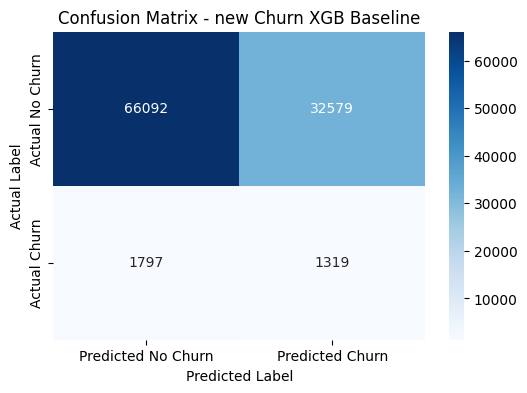



Top 15 Features by Importance
                      Feature  Importance
0                       price    0.270229
1                signup_month    0.066864
2          signup_day_of_week    0.063876
3         contacted_within_7d    0.061183
4       days_to_first_contact    0.059339
5               product_prd_2    0.000000
6             age_group_30-45    0.055126
7             age_group_46-60    0.061580
8             age_group_61-75    0.065243
9               age_group_75+    0.051873
10                gender_male    0.061767
11   first_case_reason_signup    0.057988
12  first_case_reason_support    0.000000
13   first_case_channel_email    0.055668
14   first_case_channel_phone    0.069265


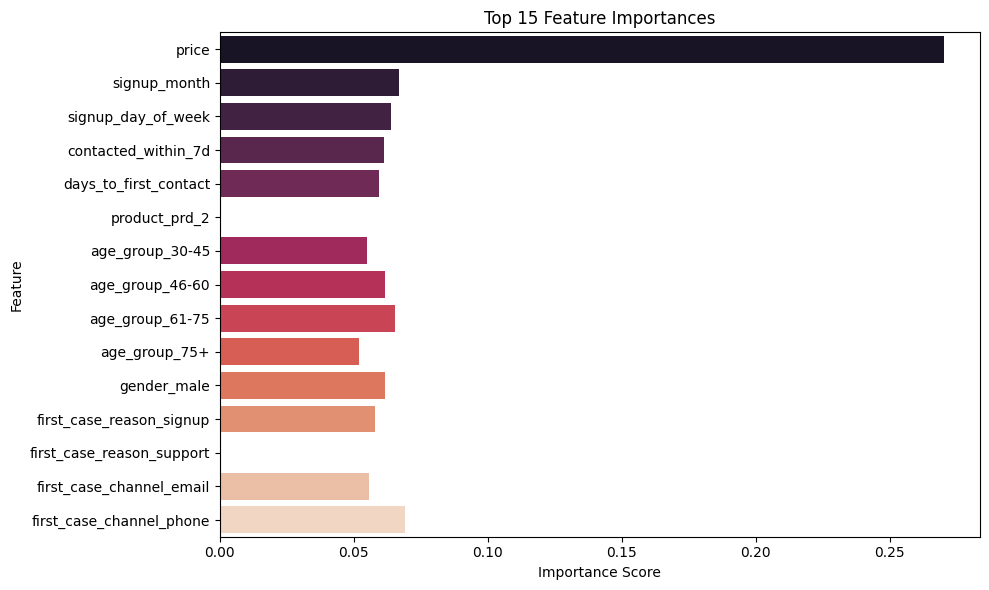

In [65]:
new_xgb_metrics = evaluate_model(xgb_model_new, X_test_new, y_test_new, 'new Churn XGB Baseline')

try:
    new_importance_scores = xgb_model_new.feature_importances_
    new_feature_importance_df = pd.DataFrame({
        'Feature': final_new_feature_names,
        'Importance': new_importance_scores
    })

    new_feature_importance_df.sort_values(by='Importance', ascending=False)

    top_n_new = 15

    print(f'\nTop {top_n_new} Features by Importance')
    print(new_feature_importance_df.head(top_n_new))

    plt.figure(figsize=(10,6))
    sns.barplot(x='Importance', y='Feature', data=new_feature_importance_df.head(top_n_new), palette='rocket')
    plt.title(f'Top {top_n_new} Feature Importances')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show

except Exception as e:
    print(f'Could not generate feature importance plot {e}')

Abysmal performance on the current model. Will try tuning it

In [66]:
xgb_base_new = xgb.XGBClassifier(
    objective = 'binary:logistic',
    eval_metric='logloss',
    use_label_encoder = False,
    random_state = 0
)

param_distributions = {
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop=1000, num=10)],
    'max_depth': [3,4,5,6,7,8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'scale_pos_weight': [5,10,15,20,24],
    'subsample': [0.7,0.8,0.9,1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

n_iterations = 50

cv_folds = 3

scoring_metric = 'average_precision'

random_search_new = RandomizedSearchCV(
    estimator = xgb_base_new,
    param_distributions = param_distributions,
    n_iter = n_iterations,
    scoring = scoring_metric,
    n_jobs = -1,
    cv = cv_folds,
    verbose = 1,
    random_state = 0
)

In [67]:
random_search_new.fit(X_train_new, y_train_new)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           num_parallel_tree=None,
                                           random_state=0, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9,
                                                             1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 7, 8],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000],
                                        'scale_pos_weight': [5, 10, 15, 20, 24],
                                        'subsample': [0.7, 0.8, 0.9, 1.0]},
                   random_state=0, scoring='average_precision', verbose=1)

In [68]:
print(f'Best Score ({scoring_metric}) found: {random_search_new.best_score_:.4f}')
print(random_search_new.best_params_)

best_xgb_model_new = random_search_new.best_estimator_

Best Score (average_precision) found: 0.0370
{'subsample': 0.7, 'scale_pos_weight': 24, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


Evaluation Report for new Churn Tuned XGB
              precision    recall  f1-score   support

No Churn (0)       0.97      0.76      0.86     98671
   Churn (1)       0.04      0.32      0.07      3116

    accuracy                           0.75    101787
   macro avg       0.51      0.54      0.46    101787
weighted avg       0.94      0.75      0.83    101787

ROC AUC Score: 0.5609
Precision-Recall Curve AUC (PRC AUC): 0.0373

 Confusion Matrix:


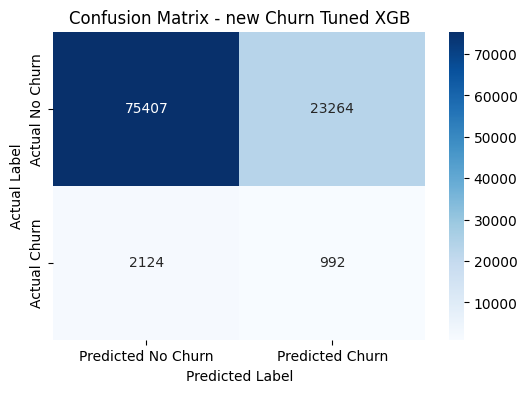

In [69]:
tuned_xgb_new_metrics = evaluate_model(
    best_xgb_model_new,
    X_test_new,
    y_test_new,
    'new Churn Tuned XGB'
)

The tuning process confirms the findings from the baseline model: The features currently available and engineered for predicting churn within the first 90 days lack sufficient predictive power. Even with optimized hyperparameters, the XGBoost model cannot reliably identify customers who will churn new based only on product info, demographics, signup timing, and basic first contact information.

### Individual Prediction Explanation (using SHAP)

In [70]:
test_probabilities = best_xgb_model.predict_proba(X_test_est)[:,1]

results_df = pd.DataFrame({
    'Actual_Churn': y_test_est,
    'Predicted_Probability': test_probabilities
}, index = X_test_est.index)

results_df_sorted = results_df.sort_values(by='Predicted_Probability', ascending=False)

display(results_df_sorted.head(10))

risk_threshold = 0.5
high_risk_list = results_df_sorted[results_df_sorted['Predicted_Probability'] >= risk_threshold]
print(f"\nIdentified {len(high_risk_list)} customers above {risk_threshold:.2f} probability threshold.")

,Actual_Churn,Predicted_Probability
106273,1,0.999996
113177,1,0.999993
109789,1,0.999990
439767,1,0.999986
436756,1,0.999986
453122,1,0.999983
441013,1,0.999982
108998,1,0.999982
440203,1,0.999979
446190,1,0.999979



Identified 1176 customers above 0.50 probability threshold.


In [71]:
if 'explainer' in locals() and shap_values is not None:
    try:
        idx_high_risk = results_df_sorted.index[0]
        idx_low_risk = results_df_sorted.index[-1]

        print('idx_high_risk')
        display(shap.force_plot(explainer.expected_value,
                                shap_values[results_df_sorted.index.get_loc(idx_high_risk),:],
                                X_test_est_df.loc[idx_high_risk,:]))
        print('idx_low_risk')
        display(shap.force_plot(explainer.expected_value,
                               shap_values[results_df_sorted.index.get_loc(idx_low_risk),:],
                               X_test_est_df.loc[idx_low_risk,:]))
    except IndexError:
        print("Could not retrieve example indices. Ensure results_df_sorted is populated.")
    except Exception as e:
        print(f"Could not generate force plots: {e}")

else:
    print("SHAP explainer or values not available for force plots.")
            

idx_high_risk


idx_low_risk
